# Simulate dropout smearing

Try to simulate a complex function f: R->R. Let a model train on it. Then shift the function up and use dropout. How good will it adapt? Will there be smearing?

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
x = np.linspace(0,10,1000, dtype=np.float32)
x


array([ 0.        ,  0.01001001,  0.02002002,  0.03003003,  0.04004004,
        0.05005005,  0.06006006,  0.07007007,  0.08008008,  0.09009009,
        0.1001001 ,  0.11011011,  0.12012012,  0.13013013,  0.14014015,
        0.15015015,  0.16016015,  0.17017017,  0.18018018,  0.1901902 ,
        0.2002002 ,  0.2102102 ,  0.22022022,  0.23023023,  0.24024025,
        0.25025025,  0.26026025,  0.27027026,  0.2802803 ,  0.2902903 ,
        0.3003003 ,  0.3103103 ,  0.3203203 ,  0.33033034,  0.34034035,
        0.35035035,  0.36036035,  0.37037036,  0.3803804 ,  0.3903904 ,
        0.4004004 ,  0.4104104 ,  0.4204204 ,  0.43043044,  0.44044045,
        0.45045045,  0.46046045,  0.47047046,  0.4804805 ,  0.4904905 ,
        0.5005005 ,  0.5105105 ,  0.5205205 ,  0.5305305 ,  0.5405405 ,
        0.5505506 ,  0.5605606 ,  0.5705706 ,  0.5805806 ,  0.5905906 ,
        0.6006006 ,  0.6106106 ,  0.6206206 ,  0.6306306 ,  0.6406406 ,
        0.6506507 ,  0.6606607 ,  0.6706707 ,  0.6806807 ,  0.69

In [8]:
f = lambda x: np.sin(x) + np.sin(x/7) + np.sin(x/5) - np.sin(x/3) + np.sin(9*x) * np.exp(-x ** 2) + 1.5 + np.random.normal(0,1e-2,x.shape)
y = f(x)


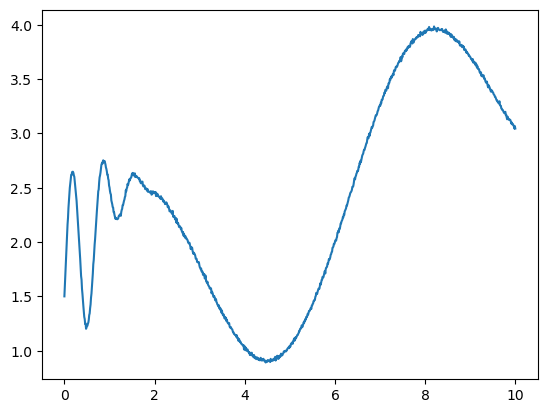

In [9]:
plt.plot(x,y)

In [10]:
from torch import nn
import torch

class LinearNet(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.do = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.do(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.do(x)
        x = self.fc3(x)
        return x

KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader,TensorDataset

train_mask = np.zeros([x.shape[0]],dtype=bool)
train_mask[:int(0.6*x.shape[0])] = 1
np.random.shuffle(train_mask)
test_mask = ~train_mask


train_set = TensorDataset(torch.from_numpy(x[train_mask]), torch.from_numpy(y[train_mask]))
train_loader = DataLoader(train_set, batch_size=16, shuffle=False)

test_set = TensorDataset(torch.from_numpy(x[test_mask]), torch.from_numpy(y[test_mask]))
test_dataloader= DataLoader(test_set, batch_size=16, shuffle=False)


In [ ]:
dataloaders = {'train':train_loader,
               'eval':test_dataloader}

In [ ]:
import time
class early_stopping_callback:
  def __init__(self,min_delta=0,patience=1):
    self.min_delta=min_delta
    self.patience=patience
    self.counter=0
    self.lowest_loss=np.inf
  def check_early_stopping(self,eval_loss):
    delta =  self.lowest_loss - eval_loss
    if delta >= self.min_delta:
      self.lowest_loss = eval_loss
      self.counter = 0
    else:
      self.counter += 1
      if counter >= patience:
        return True
    return False
  


    
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5, verbose = 0):
    since = time.time()
    if verbose > 0:
      modulo_coeff = 10
    else:
      modulo_coeff = 100

    patience = 10
    es_callback = early_stopping_callback(min_delta=0,patience=patience)

    val_acc_history = []
    for epoch in range(num_epochs):
        if epoch % modulo_coeff == 0:
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        ############ train phase ############
        phase = 'train'
        model.train()

        running_loss = 0.0
        # running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          optimizer.zero_grad()
          outputs = model(inputs.unsqueeze(1))
          loss = loss_fn(outputs, labels.unsqueeze(1).float())
          loss.backward()          
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        ############ eval phase ############
        phase = 'eval'
        model.eval()

        running_loss = 0.0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          # disable gradient tracking for speedup
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs.unsqueeze(1))
            loss = loss_fn(outputs, labels.unsqueeze(1).float())

          running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if es_callback.check_early_stopping(epoch_loss):
          print(f"Stopping early in epoch {epoch}")
          break

        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, epoch_loss))  

        val_acc_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return val_acc_history

Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 1m 58s
Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 2m 10s
Epoch 0/

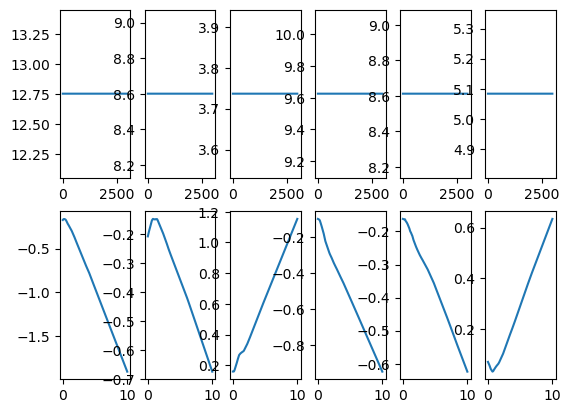

In [ ]:
sgd_parameters = {
    'lr':1e-3,        # undefined
    'momentum':0,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
loss_fn = nn.MSELoss()
dropout_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]

fig, axs = plt.subplots(2, len(dropout_list))

for idx, dropout_prob in enumerate(dropout_list):
    optimizer = torch.optim.SGD(model.parameters(), **sgd_parameters)
    model = LinearNet(dropout_prob)
    hist = train_model(model,
                    dataloaders,
                    loss_fn,
                    optimizer,
                    num_epochs=3000
                    )

    axs[0,idx].plot(hist)
    axs[1,idx].plot(x,model(torch.from_numpy(x).unsqueeze(1)).detach().numpy())

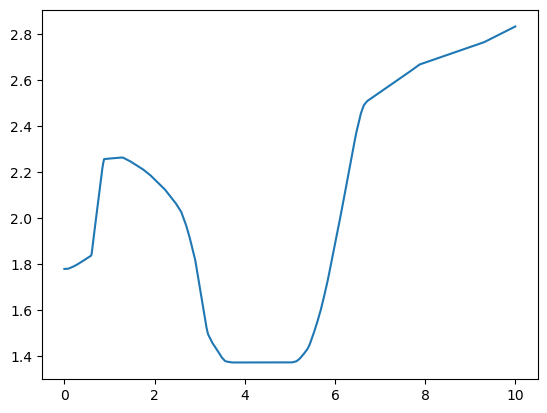

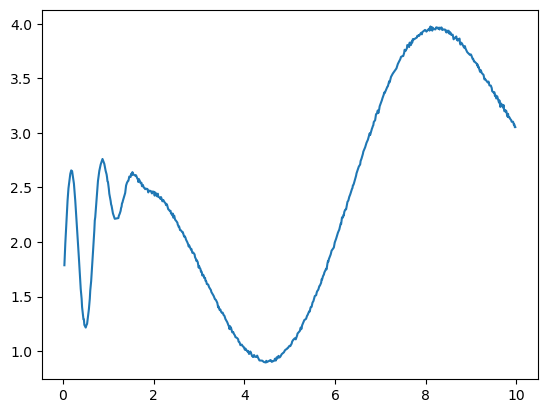

In [ ]:
plt.plot(x[train_mask],y[train_mask])

# Test with data

In [16]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
)
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from torch import nn
import torch

In [11]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
task_name = "wnli"
raw_datasets = load_dataset("glue", task_name)
label_list = raw_datasets["train"].features["label"].names
num_labels = len(label_list)
is_regression = False

model_name_or_path = "bert-base-cased"

config = AutoConfig.from_pretrained(model_name_or_path, num_labels=num_labels, finetuning_task=task_name)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    from_tf=bool(".ckpt" in model_name_or_path),
    config=config,
    ignore_mismatched_sizes=False,
    )

Found cached dataset glue (C:/Users/Valentin/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [12]:
model.config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [13]:
PretrainedConfig(num_labels=num_labels).label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [14]:
# Preprocessing the datasets
sentence1_key, sentence2_key = task_to_keys[task_name]


# Some models have set the order of the labels to use, so let's make sure we do use it.
label_to_id = None
if (
    model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id
    and task_name is not None
):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: label_name_to_id[label_list[i]] for i in range(num_labels)}
elif task_name is None:
    label_to_id = {v: i for i, v in enumerate(label_list)}

if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}
elif task_name is not None and not is_regression:
    model.config.label2id = {l: i for i, l in enumerate(label_list)}
    model.config.id2label = {id: label for label, id in config.label2id.items()}

padding = False
max_length = 128

def preprocess_function(examples):
    # Tokenize the texts
    texts = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*texts, padding=padding, max_length=max_length, truncation=True)

    if "label" in examples:
        if label_to_id is not None:
            # Map labels to IDs (not necessary for GLUE tasks)
            result["labels"] = [label_to_id[l] for l in examples["label"]]
        else:
            # In all cases, rename the column to labels because the model will expect that.
            result["labels"] = examples["label"]
    return result

processed_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation_matched" if task_name == "mnli" else "validation"]
data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=None)
batch_size = 3

train_dataloader = DataLoader(
        train_dataset, shuffle=True, collate_fn=data_collator, batch_size=batch_size
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=batch_size)


Loading cached processed dataset at C:\Users\Valentin\.cache\huggingface\datasets\glue\wnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-1e8cc9cd5feab56f.arrow
Loading cached processed dataset at C:\Users\Valentin\.cache\huggingface\datasets\glue\wnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-9b3597e227b81479.arrow
Loading cached processed dataset at C:\Users\Valentin\.cache\huggingface\datasets\glue\wnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-96346fb5d40557ef.arrow


In [38]:
import evaluate

eval_loss = 0
predicted_logits = torch.empty(0,2)
predicted_probabilites = torch.empty(0,2)
predictions = torch.empty(0)
softmax_fn = nn.Softmax(dim=1)
metric = evaluate.load("glue", task_name)

for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        outputs = model(**batch)
        eval_loss += outputs.loss.detach().float()
    predicted_logits = torch.cat([predicted_logits, outputs.logits],dim=0)
    predicted_probabilites = torch.cat([predicted_probabilites, softmax_fn(outputs.logits)],dim=0)
    preds = outputs.logits.argmax(dim=-1) if not is_regression else outputs.logits.squeeze()
    predictions = torch.cat([predictions, preds],dim=0)
    metric.add_batch(
                predictions=preds,
                references=batch["labels"],
    )


eval_metric = metric.compute()
print(eval_metric)
print(eval_loss/len(eval_dataloader))
    # predictions, references = accelerator.gather((predictions, batch["labels"]))

{'accuracy': 0.5915492957746479}
tensor(0.6878)


In [27]:
import pandas as pd
df = pd.DataFrame(torch.concat([predicted_logits,
                                predicted_probabilites,
                                torch.unsqueeze(predictions,1)],dim=1).numpy(),
                  columns=["l_0","l_1","p_0","p_1","y_hat"])
df

,l_0,l_1,p_0,p_1,y_hat
0,-0.301297,-0.347386,0.511520,0.488480,0.0
1,-0.298291,-0.300719,0.500607,0.499393,0.0
2,-0.314659,-0.313842,0.499796,0.500204,1.0
3,-0.353209,-0.430968,0.519430,0.480570,0.0
4,-0.363194,-0.375470,0.503069,0.496931,0.0
...,...,...,...,...,...
66,0.106790,0.203237,0.475907,0.524093,1.0
67,-0.352418,-0.415125,0.515672,0.484328,0.0
68,-0.319049,-0.367927,0.512217,0.487783,0.0
69,-0.292743,-0.321862,0.507279,0.492721,0.0


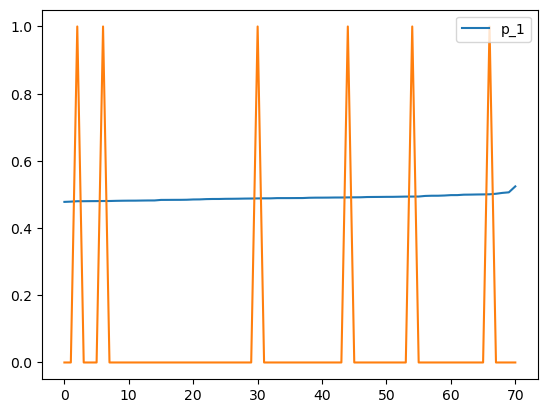

In [34]:
df.sort_values(by="p_1").reset_index().plot(y="p_1").plot(df["y_hat"])